In [102]:
import os
import re

import pandas as pd
import skimage as ski
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

tf.test.is_gpu_available()

True

In [3]:
def path(text):
    return os.path.join(*text.split("/"))

# Parameters

In [77]:
DATASET_PATH = path("../dataset.csv")
KS_IMAGES_PATH = path("../../../ksc-data/images")
FEATURES_PATH = path("../features/old.vgg19.npy")

SEED = 42
TRAIN_TEST_SPLIT_SIZE = 0.7
CLASSES = ['Ia', 'IIb', 'IIIb']
WITH_OTHER = True  # If True, kidney stones which don't fall into preceding 'CLASSES' will be put in an 'Other' class

BATCH_SIZE = 64

# Dataset loading

In [19]:
df = pd.read_csv(DATASET_PATH)

In [20]:
df.head()

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC
0,Ia_SEC_1.jpg,Ia,I,a,jpg,False,True
1,Ia_SEC_10.jpg,Ia,I,a,jpg,False,True
2,Ia_SEC_11.jpg,Ia,I,a,jpg,False,True
3,Ia_SEC_12.jpg,Ia,I,a,jpg,False,True
4,Ia_SEC_13.jpg,Ia,I,a,jpg,False,True


In [28]:
filtered_df = df

In [40]:
rng = np.random.default_rng(SEED)
indices = filtered_df.index.values
rng.shuffle(indices)

In [30]:
features = np.load(FEATURES_PATH)
features.shape

(203, 4, 7, 7, 512)

In [31]:
X = features[indices]

In [48]:
def classes_mapper(y):
    try:
        return CLASSES.index(y)
    except Exception as e:
        if WITH_OTHER:
            return len(CLASSES)
        raise e

In [49]:
Y_classes = filtered_df.stone_class.values[indices]

In [50]:
Y = np.asarray(list(map(classes_mapper, Y_classes)))

In [32]:
train_size = int(TRAIN_TEST_SPLIT_SIZE * X.shape[0])

In [73]:
X_train = X[:train_size]
Y_train = Y[:train_size]

Y_train = np.reshape(Y_train, (Y_train.shape[0], -1))
Y_train = np.repeat(Y_train, X_train.shape[1], axis=-1)
Y_train = np.reshape(Y_train, (-1,))
print(f"Y_train.shape = {Y_train.shape}")

X_train = np.reshape(X_train, (-1,) + X_train.shape[2:])
X_train = np.reshape(X_train, (X_train.shape[0], -1))
print(f"X_train.shape = {X_train.shape}")

Y_train.shape = (568,)
X_train.shape = (568, 25088)


In [74]:
X_test = X[train_size:]
Y_test = Y[train_size:]

X_test = X_test[:, 0, ...]
X_test = np.reshape(X_test, (-1,) + X_test.shape[1:])
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(f"X_test.shape = {X_test.shape}")

print(f"Y_test.shape = {Y_test.shape}")

X_test.shape = (61, 25088)
Y_test.shape = (61,)


# Model creation

In [76]:
hidden_layers = (2000, 500, 100)
nb_classes = len(CLASSES) + int(WITH_OTHER)

In [79]:
classifier = MLPClassifier(hidden_layers, batch_size=BATCH_SIZE, verbose=True, random_state=SEED)

In [80]:
classifier.fit(X_train, Y_train)

Iteration 1, loss = 9.47880419
Iteration 2, loss = 3.44161575
Iteration 3, loss = 0.64284072
Iteration 4, loss = 0.21540170
Iteration 5, loss = 0.01240974
Iteration 6, loss = 0.00957619
Iteration 7, loss = 0.00783482
Iteration 8, loss = 0.00443931
Iteration 9, loss = 0.00740803
Iteration 10, loss = 0.00471154
Iteration 11, loss = 0.00533822
Iteration 12, loss = 0.00447558
Iteration 13, loss = 0.00443988
Iteration 14, loss = 0.00442906
Iteration 15, loss = 0.00442068
Iteration 16, loss = 0.00441529
Iteration 17, loss = 0.00441177
Iteration 18, loss = 0.00440901
Iteration 19, loss = 0.00440613
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(batch_size=64, hidden_layer_sizes=(2000, 500, 100), verbose=True)

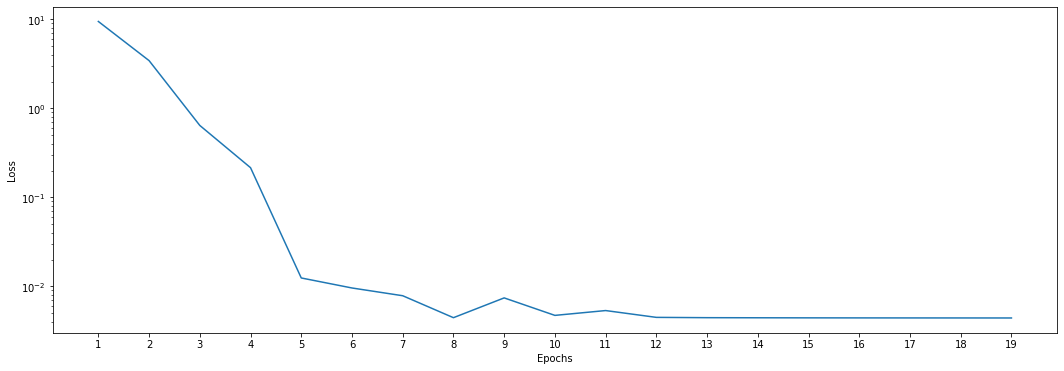

In [115]:
plt.figure(figsize=(18,6))
xticks = np.arange(classifier.n_iter_) + 1
plt.plot(xticks, classifier.loss_curve_);
plt.yscale('log');
plt.xticks(xticks);
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [96]:
classifier.score(X_test, Y_test)

0.8524590163934426

# Test model performances

In [121]:
def inverse_class_mapper(pred):
    return (CLASSES + ['Other'] if WITH_OTHER else CLASSES)[pred]

In [97]:
Y_pred = classifier.predict(X_test)

In [101]:
class_labels = CLASSES + ['Other'] if WITH_OTHER else CLASSES
print(classification_report(Y_test, Y_pred, target_names=class_labels))

              precision    recall  f1-score   support

          Ia       0.88      1.00      0.94        15
         IIb       1.00      0.80      0.89         5
        IIIb       0.54      1.00      0.70         7
       Other       0.96      0.76      0.85        34

    accuracy                           0.85        61
   macro avg       0.85      0.89      0.84        61
weighted avg       0.90      0.85      0.86        61



In [134]:
test_df = pd.DataFrame(filtered_df.iloc[indices][train_size:])

In [143]:
inverse_class_mapper(0)

'Ia'

In [139]:
Y_classes[train_size:]

array(['IIIa', 'Va', 'Ia', 'IVa2', 'IIb', 'IVc', 'IVa2', 'Ia', 'Ia',
       'IVa1', 'IVd', 'Ia', 'Ib', 'Ia', 'Id', 'Id', 'VIa', 'IVa1', 'IIIb',
       'IIIb', 'Ia', 'Va', 'IIIa', 'Ia', 'Va', 'IVb', 'IIIb', 'IIb', 'Ia',
       'IIIb', 'Ia', 'Ia', 'Ia', 'IIb', 'IIa', 'Ia', 'Ia', 'VIa', 'IVa1',
       'IIb', 'Ia', 'IVd', 'IIIb', 'IIIb', 'IIIb', 'IVd', 'IIIb', 'IIIb',
       'IVa2', 'Ia', 'IIb', 'IIb', 'Id', 'Ia', 'IIIb', 'IIIb', 'IVc',
       'IVa1', 'Ia', 'Ib', 'IIIb'], dtype=object)

In [141]:
print(list(map(classes_mapper, Y_classes[train_size:])))

[3, 3, 0, 3, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 3, 3, 2, 2, 0, 3, 3, 0, 3, 3, 2, 1, 0, 2, 0, 0, 0, 1, 3, 0, 0, 3, 3, 1, 0, 3, 2, 2, 2, 3, 2, 2, 3, 0, 1, 1, 3, 0, 2, 2, 3, 3, 0, 3, 2]


In [145]:
print(Y_test)

[3 3 3 3 3 3 3 3 3 1 3 2 3 0 0 3 1 0 2 3 3 3 0 3 3 0 0 0 3 3 3 0 3 3 2 3 1
 3 3 0 3 3 2 3 2 0 1 0 1 3 3 3 3 0 3 0 0 3 2 0 2]


In [144]:
print(Y_pred)

[3 3 3 3 3 2 3 3 2 3 2 2 3 0 0 3 1 0 2 3 0 3 0 3 3 0 0 0 2 3 3 0 3 3 2 3 1
 0 3 0 2 3 2 3 2 0 1 0 1 3 2 3 3 0 3 0 0 3 2 0 2]


In [135]:
test_df['y_pred'] = list(map(inverse_class_mapper, Y_pred))
test_df['y_true'] = list(map(inverse_class_mapper, Y_test))

In [136]:
test_df['correct'] = Y_pred == Y_test

In [137]:
test_df

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC,y_pred,y_true,correct
38,IIIa_SUR_3.png,IIIa,III,a,png,True,False,Other,Other,True
88,Va_SUR_3.png,Va,V,a,png,True,False,Other,Other,True
125,Ia_SEC_1.jpg,Ia,I,a,jpg,False,True,Other,Other,True
70,IVa2_SUR_1.png,IVa2,IV,a2,png,True,False,Other,Other,True
149,IIb_SUR_2.jpg,IIb,II,b,jpg,True,False,Other,Other,True
...,...,...,...,...,...,...,...,...,...,...
34,IVc_SEC_4.png,IVc,IV,c,png,False,True,Ia,Ia,True
179,IVa1_SUR_1.png,IVa1,IV,a1,png,True,False,Other,Other,True
146,Ia_SUR_8.jpg,Ia,I,a,jpg,True,False,IIIb,IIIb,True
162,Ib_SEC_4.png,Ib,I,b,png,False,True,Ia,Ia,True


In [ ]:
test_df.groupby(['stone_class', 'SUR', 'SEC'])

In [ ]:
def create_classifier(input_shape, layers, nb_classes):
    X = tf.keras.Input(shape=input_shape)
    
    processing = X
    for layer in layers:
        if type(layer) is int:
            processing = tf.keras.layers.Dense(layer, activation='relu')